# Решение задачи минимизации с ограничениями с помощью двойственности

In [1]:
import time

import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Основные объекты

### Прямая задача (Primal problem)

Определим прямую задачу:

\begin{align*}
& \underset{\mathbf{x}}{\text{min}}
& & f_0(\mathbf{x}) \\
& \text{s.t.}
& & f_i(\mathbf{x}) \leq 0, \quad i = 1, \dots, m \\
& & & h_j(\mathbf{x}) = 0, \quad j = 1, \dots, p
\end{align*} \quad \quad \quad (1)

где:
- $x \in \mathbb{R}^n$ --- вектор переменных оптимизации,
- $f_0: \mathbb{R}^n \to \mathbb{R}$ --- целевая функция,
- $f_i: \mathbb{R}^n \to \mathbb{R}$ --- функции ограничений-неравенств,
- $h_j: \mathbb{R}^n \to \mathbb{R}$ --- функции ограничений-равенств.

### Двойственная функция (Lagrange dual function)
Определим к прямой задаче (1) двойственную функцию. Двойственная функция это 

$$
g(\lambda, \nu) = \inf_{x \in \mathcal{D}} \{ \ f_0(\mathbf{x}) + \sum_{i=1}^{m} \lambda_i f_i(\mathbf{x}) + \sum_{j=1}^{p} \nu_j h_j(\mathbf{x}) \ \}
$$
, где $\mathcal{D}$ --- область определения всех функций (пересечение их областей), $g: \mathbb{R}^m \times \mathbb{R}^p \to \mathbb{R}$, и $\lambda \in \mathbb{R}^m, \nu \in \mathbb{R}^p$ (переменные $\lambda$ и $\nu$ назовем двойственными множителями).

Свойства $g(\lambda, \nu)$:
1) $g(\lambda, \nu)$ - вогнутая функция даже тогда, когда (1) не выпукла.
2) если $\lambda \succeq 0$, то $g(\lambda, \nu) \leq f^*$ **внутри допустимой области** (1)

### Двойственная задача (Dual Problem)

Двойственная задача формулируется как задача максимизации:

\begin{align*}
& \underset{\boldsymbol{\lambda}, \boldsymbol{\nu}}{\text{max}}
& & g(\boldsymbol{\lambda}, \boldsymbol{\nu}) \\
& \text{s.t.}
& & \lambda \succeq 0
\end{align*} \quad \quad \quad (2)

Для каждой прямой задачи можно построить двойственную. Эта задача часто оказывается проще для решения и предоставляет нижнюю границу для оптимального значения исходной задачи.

Свойства (2):
1) $\max_{\lambda \geq 0, \nu} g(\lambda, \nu) \leq f^*$ на всем $\mathcal{D}$ (неформально говоря (2) как бы "штрафует" за выход $x$ за пределы допустимого множества)
2) $f(x) - \max_{\lambda \geq 0, \nu} g(\lambda, \nu) \leq \varepsilon \implies f(x) - f^* \leq \varepsilon$. Это свойство так же называют "зазором двойственности" (duality gap)
3) $f(x) - \max_{\lambda \geq 0, \nu} g(\lambda, \nu) = 0$, то $x$ - решение прямой задачи (1), НО при соблюдении определенных условий (например, условия Слейтера, но есть и другие).

![Прямая и двойственная функции](dual_fun.png)

*Рис. 1: Сплошной линией изображена исходная функция. Пунктирной линией функция ограничений-неравенств. Точечная линия - лагранжиан. Источник: Boyd, Stephen P., and Lieven Vandenberghe. Convex optimization. Cambridge university press, 2004.*

# Пример 1. Решение системы линейных уравнений методом наименьших квадратов

Рассмотрим задачу
$$
\begin{array}{ll}
    \text{min} & x^T x \\
    \text{s.t.} & Ax = b,
\end{array}
$$

где $A \in \mathbb{R}^{p \times n}$. Эта задача не имеет неравенств и содержит $p$ (линейных) равенств. 
Лагранжиан имеет вид
$$
L(x, \nu) = x^T x + \nu^T (Ax - b),
$$

с областью определения $\mathbb{R}^n \times \mathbb{R}^p$. Тут $x^* = −(1/2)A^\top ν$ и тогда двойственная функция имеет вид
$$
g(ν) = L(−(1/2)A^\top ν, ν) = −(1/4)ν^\top AA^\top ν − b^\top ν
$$

А двойственная задача

$$
\begin{array}{ll}
    \text{max}_\nu & −(1/4)ν^\top AA^\top ν − b^\top ν \\
\end{array}
$$

Далее проверим на сколько решение двойственной задачи совпадает с решением прямой.

In [2]:
np.random.seed(1)
m, n = 50, 1000
A = np.random.randn(m, n)
b = np.random.randn(m)

# --- Primal problem ---
x = cp.Variable(n)
primal_obj = cp.Minimize(cp.sum_squares(x))
constraints = [A @ x == b]
primal_prob = cp.Problem(primal_obj, constraints)
primal_val = primal_prob.solve()
x_star = x.value

# --- Dual problem ---
nu = cp.Variable(m)
dual_obj = cp.Maximize(-0.25 * cp.quad_form(nu, A @ A.T) - b @ nu)
dual_prob = cp.Problem(dual_obj)
dual_val = dual_prob.solve()
nu_star = nu.value

print("Primal optimal value:", primal_val)
print("Dual optimal value:", dual_val)
print("Duality gap:", primal_val - dual_val)

Primal optimal value: 0.05883737775872147
Dual optimal value: 0.05883737775872144
Duality gap: 2.7755575615628914e-17


# Пример 2. Entropy maximization

Прямая задача имеет вид
$$
\begin{array}{ll}
    \text{min} & \sum_{i=1}^n x_i \log x_i \\
    \text{s.t.} & A x \leq b, \ \mathbf{1}^T x = 1, \ x \in \mathbb{R}^n_{+}.
\end{array}
$$

Соответствующая двойственная задача

$$
\begin{array}{ll}
    \text{max}_{\lambda, \nu} & - b^T \lambda - \nu - e^{-\nu - 1}
    \sum_{i=1}^n e^{-a_i^T \lambda}, \\
    \text{s.t.} & \lambda \succeq 0,
\end{array}
$$

In [3]:
np.random.seed(1)
m, n = 500, 1500
A = np.random.randn(m, n)
b = np.random.randn(m) + 2  # to ensure feasibility

# --------------------
# Primal problem
# --------------------
x = cp.Variable(n, nonneg=True)
primal_obj = cp.Minimize(-cp.sum(cp.entr(x)))  # sum x log x
primal_constraints = [A @ x <= b, cp.sum(x) == 1]
primal_prob = cp.Problem(primal_obj, primal_constraints)
primal_val = primal_prob.solve()
print("Primal optimal value:", primal_val)
# print("Primal x*:", x.value)

# --------------------
# Dual problem
# --------------------
lam = cp.Variable(m, nonneg=True)
nu = cp.Variable()
S = cp.sum(cp.exp(-(A.T @ lam) - nu - 1))   # sum_i exp(-a_i^T lam)
g_expr = -b @ lam - nu - S
dual_prob = cp.Problem(cp.Maximize(g_expr))
dual_val = dual_prob.solve()
print("Dual optimal value:", dual_val)
# print("Dual lambda*:", lam.value)
# print("Dual nu*:", nu.value)

# --------------------
# Duality gap
# --------------------
print("Duality gap:", primal_val - dual_val)

Primal optimal value: -6.725963869038807
Dual optimal value: -6.725963892312716
Duality gap: 2.3273909022236694e-08


# Пример 3. Зазор двойственности как критерий останова. Решение двух задач параллельно.

Тут мы будем использовать зазор двойственности в качестве метрики близости к решению.

В стандартной форме прямая задача линейного программирования (см. Boyd, §5.1.2, пример *Lagrange dual of standard form LP*) имеет вид:

$$
\begin{aligned}
\text{(Primal)} \quad
& \min_{x \in \mathbb{R}^n} \; c^\top x \\
& \text{s.t. } A x = b, \; x \ge 0.
\end{aligned}
$$

Снова записываем двойственную функцию:

$$
g(\nu, \lambda) = \inf_x \{  c^\top x + \nu^\top (Ax - b) - \lambda^\top x \}, \quad \lambda \ge 0.
$$

Условие ограниченности $g(\nu, \lambda) > -\infty$ даёт
$$
c + A^\top \nu - \lambda = 0 \quad \Rightarrow \quad \lambda = A^\top \nu + c \ge 0.
$$

Подставляя обратно, получаем двойственную задачу:

$$
\begin{aligned}
\text{(Dual)} \quad
& \max_{\nu \in \mathbb{R}^m} \; -b^\top \nu \\
& \text{s.t. } A^\top \nu + c \ge 0.
\end{aligned}
$$

Таким образом, каждая итерация нашего алгоритма будет минимизировать прямую задачу (с проекцией на допустимое множество) и одновременно двигаться по двойственной переменной $\nu$, сохраняя условие $A^\top \nu + c \ge 0$.


In [4]:
class StepSize:
    def __call__(self, x, h, k, *args, **kwargs):
        raise NotImplementedError

class ConstantStep(StepSize):
    def __init__(self, alpha):
        self.alpha = float(alpha)
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha

In [5]:
def primal_LP_value(c):
    def f(x):
        return float(c.dot(x))
    return f

def grad_primal_LP(c):
    def gradf(x):
        return c
    return gradf

def dual_LP(A, b, c):
    def f(nu):
        return float(-b.dot(nu))
    return f

def grad_dual_f(b):
    def gradf(nu):
        return -b
    return gradf


Чтобы оставаться в допустимой области:

- Для прямой задачи проецируем точку на множество $\{x : A x = b, x \ge 0\}$.  
  Это эквивалентно задаче квадратичного программирования.

- Для двойственной задачи проецируем на множество $\{\nu : A^\top \nu + c \ge 0\}$.


In [6]:
def primal_LP_proj(A, b):
    """Проекция на {x: A x = b, x >= 0}"""
    def f(x):
        n = x.shape[0]
        x_var = cp.Variable(n)
        obj = cp.Minimize(0.5 * cp.sum_squares(x_var - x))
        cons = [A @ x_var == b, x_var >= 0]
        prob = cp.Problem(obj, cons)
        prob.solve(verbose=False)
        if prob.status in ['optimal', 'optimal_inaccurate']:
            return np.array(x_var.value, dtype=float)
        else:
            return None
    return f

def dual_proj(A, c):
    """Проекция на {ν: A^T ν + c >= 0}"""
    def f(lamda):
        m = lamda.shape[0]
        lam_var = cp.Variable(m)
        obj = cp.Minimize(0.5 * cp.sum_squares(lam_var - lamda))
        cons = [A.T @ lam_var + c >= 0]
        prob = cp.Problem(obj, cons)
        prob.solve(verbose=False)
        if prob.status in ['optimal', 'optimal_inaccurate']:
            return np.array(lam_var.value, dtype=float)
        else:
            return None
    return f


Здесь реализован метод чередования шагов:

1. Обновляем $x$ прямой задачи градиентным шагом и делаем проекцию.  
2. Обновляем $\nu$ градиентным шагом в направлении градиента (т.к. тут максимизация) и проецируем на область $A^\top \nu + c \ge 0$.  
3. Вычисляем текущие значения $f(x)$, $g(\nu)$, лагранжевы множители $\lambda = A^\top \nu + c$.  
4. Считаем **зазор двойственности**:
   $$
   \text{gap}_k = f(x_k) - g(\nu_k).
   $$

История сохраняется в `self.full_history`.


In [7]:
class PrimalDualGradientDescentAscent:
    def __init__(self, A, b, c,
                 f, gradf, 
                 dual_f, grad_dual_f, 
                 PrimalStepSizeChoice, DualStepSizeChoice, 
                 primal_proj, dual_proj,
                 return_history=True):

        self.f = f
        self.gradf = gradf
        self.dual_f = dual_f
        self.grad_dual_f = grad_dual_f
        self.A = np.array(A, dtype=float)
        self.b = np.array(b, dtype=float)
        self.c = np.array(c, dtype=float)
        self.m, self.n = self.A.shape

        self.PrimalStepSizeChoice = PrimalStepSizeChoice
        self.DualStepSizeChoice = DualStepSizeChoice
        self.primal_proj = primal_proj
        self.dual_proj = dual_proj
        self.return_history = return_history

        self.primal_history = []
        self.dual_history = []
        self.full_history = []

    def solve(self, x0=None, nu0=None, eps=1e-8, max_iter=20, verbose=False):
        if x0 is None:
            x_var = cp.Variable(self.n)
            prob = cp.Problem(cp.Minimize(0), [self.A @ x_var == self.b, x_var >= 0])
            prob.solve(verbose=False)
            if prob.status in ['optimal', 'optimal_inaccurate']:
                x = np.array(x_var.value, dtype=float)
            else:
                x = np.maximum(np.linalg.lstsq(self.A, self.b, rcond=None)[0], 0.0)
        else:
            x = np.array(x0, dtype=float)

        if nu0 is None:
            nu = np.zeros(self.m, dtype=float)
        else:
            nu = np.array(nu0, dtype=float)

        now = time.time()
        self.primal_history = [(x.copy(), now)]
        self.dual_history = [(nu.copy(), now)]
        self.full_history = []

        for k in range(max_iter):
            primal_grad_f = self.gradf(x)
            x_new = x - self.PrimalStepSizeChoice(x, -primal_grad_f, k, self.f) * primal_grad_f
            x_new = self.primal_proj(x_new)
            if x_new is None:
                raise RuntimeError("Primal infeasible")
            x = x_new
            if self.return_history:
                self.primal_history.append((x.copy(), time.time()))

            nu_new = nu + self.DualStepSizeChoice(nu, self.grad_dual_f(nu), k, self.dual_f) * self.grad_dual_f(nu)
            nu_new = self.dual_proj(nu_new)
            if nu_new is None:
                raise RuntimeError("Dual infeasible")
            nu = nu_new
            if self.return_history:
                self.dual_history.append((nu.copy(), time.time()))

            lam = self.A.T.dot(nu) + self.c
            fval = self.f(x)
            gval = self.dual_f(nu)
            gap = fval - gval

            if self.return_history:
                self.full_history.append((x.copy(), nu.copy(), lam.copy(), float(gap), time.time()))

            if verbose:
                print(f"iter {k:3d} | f(x)={fval:.6e}  g(nu)={gval:.6e}  gap={gap:.6e}")

            if gap <= eps:
                if verbose:
                    print("Stopping: duality gap <= eps")
                break

        return x, nu, lam, gap, k


In [8]:
np.random.seed(42)
A = np.random.randn(3, 3)
x_true = np.random.rand(3)
b = A.dot(x_true)
c = np.random.randn(3)

primal_f = primal_LP_value(c)
dual_f = dual_LP(A, b, c)

primal_step = ConstantStep(1e-2)
dual_step = ConstantStep(1e-1)

primal_proj = primal_LP_proj(A, b)
dual_proj = dual_proj(A, c)

solver = PrimalDualGradientDescentAscent(A, b, c,
                         primal_f, grad_primal_LP(c),
                         dual_f, grad_dual_f(b),
                         primal_step, dual_step,
                         primal_proj, dual_proj, return_history=True)

x_opt, nu_opt, lam_opt, gap, iters = solver.solve(eps=1e-4, max_iter=1000, verbose=True)

print("done iters:", iters)
print("x_opt:", x_opt)
print("nu_opt:", nu_opt)
print("x_true:", x_true)
print("lambda (A^T nu + c):", lam_opt)
print("primal value:", c.dot(x_opt))
print("dual value:", -b.dot(nu_opt))
print("final gap:", gap)


iter   0 | f(x)=-9.135971e-02  g(nu)=-6.669241e-01  gap=5.755644e-01
iter   1 | f(x)=-9.135971e-02  g(nu)=-6.539615e-01  gap=5.626018e-01
iter   2 | f(x)=-9.135971e-02  g(nu)=-6.409989e-01  gap=5.496392e-01
iter   3 | f(x)=-9.135971e-02  g(nu)=-6.280364e-01  gap=5.366766e-01
iter   4 | f(x)=-9.135971e-02  g(nu)=-6.150738e-01  gap=5.237141e-01
iter   5 | f(x)=-9.135971e-02  g(nu)=-6.021112e-01  gap=5.107515e-01
iter   6 | f(x)=-9.135971e-02  g(nu)=-5.891486e-01  gap=4.977889e-01
iter   7 | f(x)=-9.135971e-02  g(nu)=-5.761860e-01  gap=4.848263e-01
iter   8 | f(x)=-9.135971e-02  g(nu)=-5.632234e-01  gap=4.718637e-01
iter   9 | f(x)=-9.135971e-02  g(nu)=-5.502609e-01  gap=4.589012e-01
iter  10 | f(x)=-9.135971e-02  g(nu)=-5.372983e-01  gap=4.459386e-01
iter  11 | f(x)=-9.135971e-02  g(nu)=-5.243357e-01  gap=4.329760e-01
iter  12 | f(x)=-9.135971e-02  g(nu)=-5.113731e-01  gap=4.200134e-01
iter  13 | f(x)=-9.135971e-02  g(nu)=-4.984105e-01  gap=4.070508e-01
iter  14 | f(x)=-9.135971e-02  g(n

Зазор двойственности $\text{gap}(k) = f(x_k) - g(\nu_k)$

По слабой двойственности всегда $\text{gap}(k) \ge 0$.  
При приближении к оптимальному решению $\text{gap}(k) \to 0$.

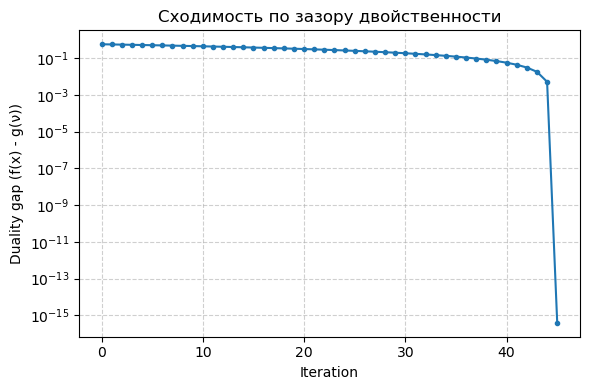

In [9]:
dual_gaps = [entry[3] for entry in solver.full_history]
iters = list(range(len(dual_gaps)))

plt.figure(figsize=(6,4))
plt.plot(iters, dual_gaps, marker='o', linewidth=1.5, markersize=3)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Duality gap (f(x) - g(ν))")
plt.title("Сходимость по зазору двойственности")
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Пример 4. Логистическая регрессия. Зазор двойственности через связь между прямой и двойственной переменными.

Рассмотрим задачу логистической регрессии:

$$\min_{w\in\mathbb{R}^n} \frac{1}{m} \sum\limits_{i=1}^m \log\left(1+\exp(-y_i \langle w, x_i\rangle)\right) + \frac{\alpha}{2}\|w\|_2^2,$$
где $\{x_i, y_i\}_{i=1}^m \in \mathbb{R}^n\times \{-1,1\}$ есть обучающая выборка, $\alpha\in\mathbb{R}_+$ - некоторый параметр $\ell_2$-регуляризации, $\alpha=0.01$.

В качестве критерия останова и измерения невязки мы будем использовать зазор двойственности. Заметим, что для задачи выше построить двойственную нельзя в силу отсутсвия ограничений. Однако, в таком случае можно переписать задачу выше введя новые переменные и ограничения:
$$\min_{u\in\mathbb{R^m}, w\in\mathbb{R}^n} \frac{1}{m} \sum\limits_{i=1}^m \log\left(1+\exp(-u_i)\right) + \frac{\alpha}{2}\|w\|_2^2,$$
$$\text{s.t. } u_i=y_i \langle w, x_i\rangle, \forall i=\overline{1,m}.$$

Выразим зазор двойственности в таком виде:
$$
\text{gap}(w_k)=f(w_k)-g(\nu(w_k))
$$

Тогда двойственная функция имеет вид:
$$
g(\nu) = \inf_{u, w} \left( \frac{1}{m} \sum\limits_{i=1}^m \log\left(1+\exp(-u_i)\right) + \frac{\alpha}{2}\|w\|_2^2 + \nu (u - y \circ \langle w, X\rangle) \right)
$$

Заметим, что имеет место два факта:
- ограничения всегда соблюдены, т.к. $w_k$ генерируется на каждой итерации при решении изначальной задачи без ограничений.
- выполнены условия Слейтера

Из этого следует, что свойство нижней аппроксимации будет всегда выполнено $g(\nu) \leq f^*$, а так же из $g(\nu) - f(w_k) = 0$ будет следовать, что мы нашли решение.

Найдем минимум через производную:
$$
\nabla_{u_i} g(\nu) = \frac{1}{m} \left( - \frac{1}{1 + \exp{u_i}} \right) + \nu_i = 0
$$

$$
\nabla_{w} g(\nu) = \alpha w - y \circ \nu^\top X = 0
$$

Затем выразим $w$ и $u$ через $\nu$:
$$
w = \frac{1}{\alpha} y \circ \nu^\top X
$$

$$
u_i = \log \frac{1 - m \nu_i}{m \nu_i} \quad \quad \quad (3)
$$

и подставив в $g$ получим функию, зависящую только от $\nu$:
$$
g(\nu) = - \frac{1}{m} \sum_{i=1}^{m} \left( m \nu_i \log (m \nu_i) + (1 - m \nu_i) \log (1 - m \nu_i) \right) - \frac{1}{2 \alpha} \| y \circ X^\top \nu \|
$$

Заметим, что область определения такой функции $\nu_i \in (0, \frac{1}{m})$. 

На каждой итерации двойственную переменную удобнее будет возвращать как функцию от $u$: $g(\nu(u))$, где $\nu_i = \frac{1}{m (1 + \exp(u_i))}$ из (3), а $u_i = y_i \langle w, x_i\rangle$ из функции ограничений.

In [10]:
def logistic_regression_primal_loss(X, y, alpha=1.0):
    def primal_loss(w):
        logits = X @ w
        log_exp = np.log1p(np.exp(-y * logits))
        return np.mean(log_exp) + alpha/2 * np.sum(w ** 2)

    return primal_loss

def logistic_regression_primal_grad(X, y, alpha=1.0):
    def primal_grad(w):
        logits = X @ w
        sigma = 1 / (1 + np.exp(y * logits))
        grad_loss = - (X.T @ (y * sigma)) / X.shape[0]
        grad_reg = alpha * w
        return grad_loss + grad_reg

    return primal_grad

def logistic_regression_dual_value_from_w(X, y, w, alpha):
    m = X.shape[0]
    t = y * (X @ w)
    lam = 1.0 / (1.0 + np.exp(t)) # lam is \nu * m
    eps = 1e-12
    lam = np.clip(lam, eps, 1 - eps)

    ent_term = - (1.0 / m) * np.sum(lam * np.log(lam) + (1.0 - lam) * np.log(1.0 - lam))

    ylam = y * lam
    v = X.T @ ylam
    quad_term = - (1.0 / (2.0 * alpha)) * (np.linalg.norm(v) ** 2) / (m**2)

    return ent_term + quad_term

def run():
    np.random.seed(42)
    
    X = np.load('data/X.npy')
    y = np.load('data/y.npy')

    n_samples, n_features = X.shape

    alpha = 0.1
    w = np.ones(n_features) * 1/n_features

    primal_loss = logistic_regression_primal_loss(X, y, alpha)

    gaps = []
    f_values = []
    for iteration in range(100):
        sigma = 1 / (1 + np.exp(y * (X @ w)))
        grad_w = -(X.T @ (y * sigma)) / n_samples + alpha * w
        w -= 0.01 * grad_w

        d = logistic_regression_dual_value_from_w(X, y, w, alpha)
        loss = primal_loss(w)
        gap = loss - d

        gaps.append(gap)
        f_values.append(loss)
        if gap < 1e-12:
            break
    
    return np.array(gaps), np.array(f_values)

In [11]:
dual_gaps, f_values = run()

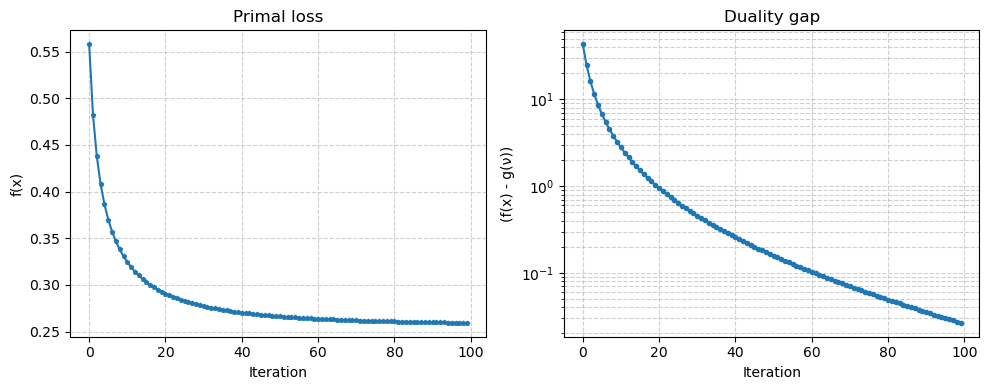

In [12]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(np.arange(f_values.shape[0]), f_values, marker='p', linewidth=1.5, markersize=3, label='Primal loss')
plt.xlabel("Iteration")
plt.ylabel("f(x)")
plt.title("Primal loss")
plt.grid(True, which="both", ls="--", alpha=0.6)

plt.subplot(1, 2, 2)
plt.plot(np.arange(dual_gaps.shape[0]), dual_gaps, marker='o', linewidth=1.5, markersize=3, label='Duality gap')
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("(f(x) - g(ν))")
plt.title("Duality gap")
plt.grid(True, which="both", ls="--", alpha=0.6)

plt.tight_layout()
plt.show()

In [13]:
def run():
    np.random.seed(42)
    n_samples, n_features = 100, 20
    X = np.random.randn(n_samples, n_features)
    y = np.random.choice([-1, 1], size=n_samples)

    reg_parameter = 0.1
    w = np.ones(n_features) * 1/n_features
    u = np.ones(n_samples) * 1/n_samples

    sym_mx_eig_min = np.linalg.eigvals(X.T @ X).min()
    strong_conv_constant = sym_mx_eig_min / (4*n_samples) + reg_parameter

    primal_loss = logistic_regression_primal_loss(X, y, reg_parameter)
    primal_loss_grad = logistic_regression_primal_grad(X, y, reg_parameter)

    dual_gaps = []
    gradient_norms = []
    gradient_dominated_gaps = []

    for iteration in range(100):
        sigma = 1 / (1 + np.exp(y * (X @ w)))
        grad_w = -(X.T @ (y * sigma)) / n_samples + reg_parameter * w
        w -= 0.01 * grad_w

        d = logistic_regression_dual_value_from_w(X, y, w, reg_parameter)
        loss = primal_loss(w)
        gap = loss - d

        dual_gaps.append(gap)

        loss_grad = primal_loss_grad(w)
        gradient_norms.append(np.linalg.norm(loss_grad))
        gradient_dominated_gaps.append((np.linalg.norm(loss_grad) ** 2) / (2 * strong_conv_constant))
        
        if gap < 1e-12:
            break
    
    return np.array(dual_gaps), np.array(gradient_norms), np.array(gradient_dominated_gaps)

In [14]:
dual_gaps, gradient_norms, gradient_dominated_gaps = run()

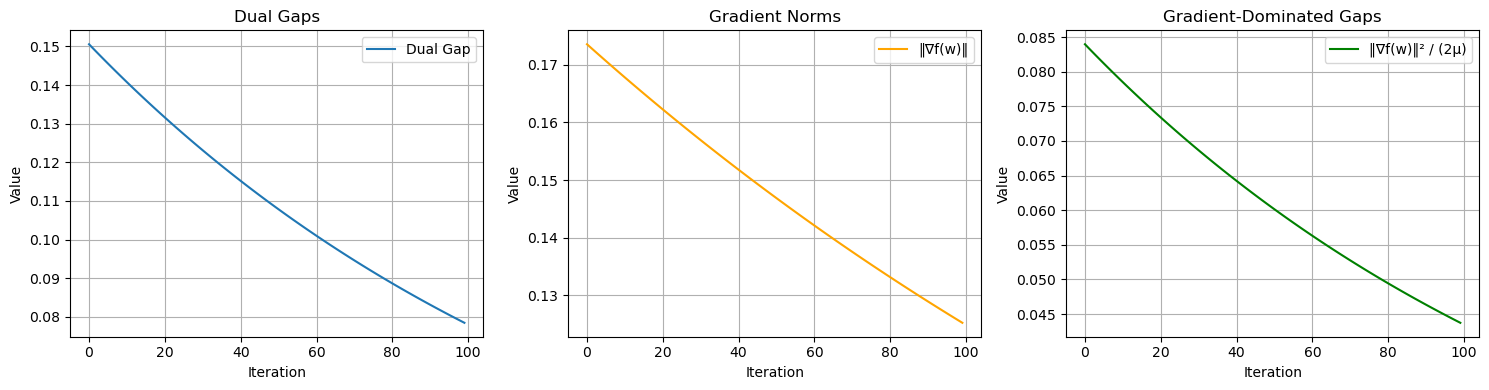

In [15]:
import matplotlib.pyplot as plt

dual_gaps, gradient_norms, gradient_dominated_gaps = run()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(dual_gaps, label='Dual Gap')
axes[0].set_title('Dual Gaps')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Value')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(gradient_norms, label='‖∇f(w)‖', color='orange')
axes[1].set_title('Gradient Norms')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Value')
axes[1].grid()
axes[1].legend()

axes[2].plot(gradient_dominated_gaps, label='‖∇f(w)‖² / (2μ)', color='green')
axes[2].set_title('Gradient-Dominated Gaps')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Value')
axes[2].grid()
axes[2].legend()

plt.tight_layout()
plt.show()

# Итог

- двойственная задача является нижней аппроксимацией прямой задаче
- максимизируя двойственную задачу мы приближаемся к минимуму прямой задачи
- зазор двойственности можно испольовать как критерий останова

Примеры 1-3 взяты из книги Boyd, Stephen P., and Lieven Vandenberghe. Convex optimization. Cambridge university press, 2004. Благодарность за пример 5 Илье Курузову.